 ### **1. Data Loading and Ingestion**

In [4]:
# Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import argparse
import os
import math
from typing import Tuple, List, Optional, Dict


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.base import TransformerMixin, BaseEstimator
import joblib

In [5]:
file_path = 'https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/EasyVisa%20(1).csv'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_and_pda(file_path):
    """
    Loads dataset, performs basic PDA
    
    Steps:
    1. Load CSV file.
    2. Basic info 
    3. missing values
    4. Check for duplicates
    5. PDA by feature type
    """

    # === 1. Load dataset ===
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully: {file_path}")
        print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

    # === 2. Basic Info ===
    print("=== DATA INFO ===")
    print(df.info())
    print("\n=== FIRST 5 ROWS ===")
    print(df.head())
    print("\n=== LAST 5 ROWS ===")
    print(df.tail())
    print("\n=== SUMMARY STATISTICS ===")
    print(df.describe().T)

    # === 3. Missing Values ===
    print("\n=== MISSING VALUE PERCENTAGES ===")
    missing = df.isnull().mean() * 100
    print(missing[missing > 0].sort_values(ascending=False))


    # === 4. Check for duplicates
    print("\n2. Duplicate Rows:")
    duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates}")
    if duplicates > 0:
        print(f"Percentage of duplicates: {(duplicates/len(df))*100:.2f}%")

    # === 5. PDA by Feature Type ===
    numerical = df.select_dtypes(include=['int64', 'float64']).columns
    categorical = df.select_dtypes(exclude=['int64', 'float64']).columns

    print(f"\nNumerical features: {list(numerical)}")
    print(f"Categorical features: {list(categorical)}")

    return df


In [7]:
df = load_and_pda(file_path)

Dataset loaded successfully: https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/EasyVisa%20(1).csv
Shape: 25480 rows × 12 columns

=== DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-nu

In [8]:
def check_unique_values(df):
    """
    Prints the number of unique values and the unique entries
    for each column in the DataFrame.
    """
    for col in df.select_dtypes(include='object'):
        unique_vals = df[col].unique()
        print(f"\nColumn: {col}")
        print(f"Unique count: {len(unique_vals)}")
        print(f"Unique values: {unique_vals}")

In [9]:
check_unique_values(df)


Column: case_id
Unique count: 25480
Unique values: ['EZYV01' 'EZYV02' 'EZYV03' ... 'EZYV25478' 'EZYV25479' 'EZYV25480']

Column: continent
Unique count: 6
Unique values: ['Asia' 'Africa' 'North America' 'Europe' 'South America' 'Oceania']

Column: education_of_employee
Unique count: 4
Unique values: ['High School' "Master's" "Bachelor's" 'Doctorate']

Column: has_job_experience
Unique count: 2
Unique values: ['N' 'Y']

Column: requires_job_training
Unique count: 2
Unique values: ['N' 'Y']

Column: region_of_employment
Unique count: 5
Unique values: ['West' 'Northeast' 'South' 'Midwest' 'Island']

Column: unit_of_wage
Unique count: 4
Unique values: ['Hour' 'Year' 'Week' 'Month']

Column: full_time_position
Unique count: 2
Unique values: ['Y' 'N']

Column: case_status
Unique count: 2
Unique values: ['Denied' 'Certified']


----------------------------------------------------------------
 ### **1. Univariate analysis**
 ---------------------------------------------------------------

In [11]:
def univariate_numerical_eda(df, column, save_folder="EDA_Charts"):
    """
    Performs univariate EDA on a single numerical column.
    Includes:
    - Summary statistics
    - Skewness, Kurtosis
    - Outlier detection (IQR-based)
    - Histogram + Boxplot
    - Saves each figure automatically to a folder
    """

    # Create folder if it doesn’t exist
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    print(f"\nFeature: {column}")
    print("="*60)
    print(df[column].describe().to_frame())

    # --- Summary ---
    total = len(df[column])
    missing = df[column].isna().sum()
    unique = df[column].nunique()

    print(f"Missing values: {missing} ({(missing/total)*100:.2f}%)")
    print(f"Unique values: {unique}")

    skew = df[column].skew()
    kurt = df[column].kurt()

    print(f"\nSkewness: {skew:.3f}")
    print(f"Kurtosis: {kurt:.3f}")

    # ====== OUTLIER CHECK (IQR Method) ======
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    n_outliers = len(outliers)
    outlier_pct = (n_outliers / len(df)) * 100

    print(f"\nOutliers detected: {n_outliers} ({outlier_pct:.2f}%)")
    print(f"Outlier range: below {lower_bound:.2f} or above {upper_bound:.2f}")

    # ====== INTERPRETATION ======
    if abs(skew) > 0.7:
        skew_status = "high"
        print(f"\n{column} is strongly skewed. Consider log, Box-Cox, or Yeo-Johnson transformation.")
    elif abs(skew) > 0.3:
        skew_status = "moderate"
        print(f"{column} is mildly skewed. A mild transformation (√ or cube root) may help.")
    else:
        skew_status = "normal"
        print(f"{column} is fairly symmetric — no transformation likely needed.")

    if abs(kurt) > 1.0:
        kurt_status = "high"
        print(f"{column} shows heavy tails (leptokurtic). Consider robust scaling or outlier treatment.")
    elif abs(kurt) > 0.5:
        kurt_status = "moderate"
        print(f"{column} has mildly heavy tails. Light transformation or scaling may help.")
    else:
        kurt_status = "normal"
        print(f"{column} has fairly normal kurtosis — suitable for most ML models.")

    # Combined skew–kurtosis insight
    if (skew_status in ["high", "moderate"]) and kurt_status == "normal":
        print("\nFocus on correcting skew (e.g., log-transform); no heavy outlier correction needed.")
    elif (skew_status in ["high", "moderate"]) and (kurt_status in ["high", "moderate"]):
        print("\nThe variable is both skewed and heavy-tailed — consider transformation and outlier capping.")
    elif skew_status == "normal" and kurt_status == "normal":
        print("\nThe variable is approximately normal — no transformation needed.")

    # ====== PLOTS ======
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram + KDE
    sns.histplot(df[column], kde=True, bins=30, color='salmon', ax=axes[0])
    axes[0].set_title(f'Distribution of {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')

    # Boxplot
    sns.boxplot(x=df[column], color='seagreen', ax=axes[1])
    axes[1].set_title(f'Boxplot of {column}')
    axes[1].set_xlabel(column)

    plt.tight_layout()

    # Save the combined figure
    save_path = os.path.join(save_folder, f"{column}_univariate_plot.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f" Saved plot for '{column}' → {save_path}")

    plt.show()
    plt.close(fig)



Feature: no_of_employees
       no_of_employees
count     25480.000000
mean       5667.043210
std       22877.928848
min         -26.000000
25%        1022.000000
50%        2109.000000
75%        3504.000000
max      602069.000000
Missing values: 0 (0.00%)
Unique values: 7105

Skewness: 12.265
Kurtosis: 206.335

Outliers detected: 1556 (6.11%)
Outlier range: below -2701.00 or above 7227.00

no_of_employees is strongly skewed. Consider log, Box-Cox, or Yeo-Johnson transformation.
no_of_employees shows heavy tails (leptokurtic). Consider robust scaling or outlier treatment.

The variable is both skewed and heavy-tailed — consider transformation and outlier capping.
 Saved plot for 'no_of_employees' → EDA_Charts\no_of_employees_univariate_plot.png


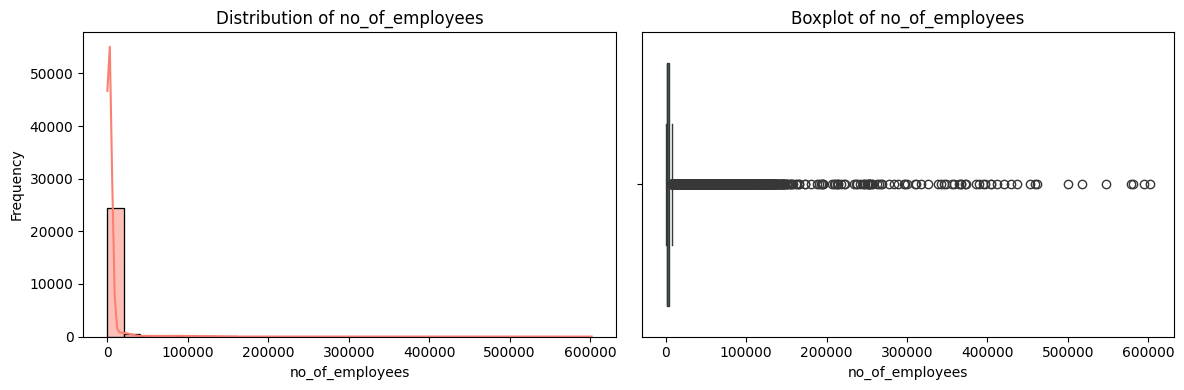


Feature: yr_of_estab
        yr_of_estab
count  25480.000000
mean    1979.409929
std       42.366929
min     1800.000000
25%     1976.000000
50%     1997.000000
75%     2005.000000
max     2016.000000
Missing values: 0 (0.00%)
Unique values: 199

Skewness: -2.037
Kurtosis: 3.507

Outliers detected: 3260 (12.79%)
Outlier range: below 1932.50 or above 2048.50

yr_of_estab is strongly skewed. Consider log, Box-Cox, or Yeo-Johnson transformation.
yr_of_estab shows heavy tails (leptokurtic). Consider robust scaling or outlier treatment.

The variable is both skewed and heavy-tailed — consider transformation and outlier capping.
 Saved plot for 'yr_of_estab' → EDA_Charts\yr_of_estab_univariate_plot.png


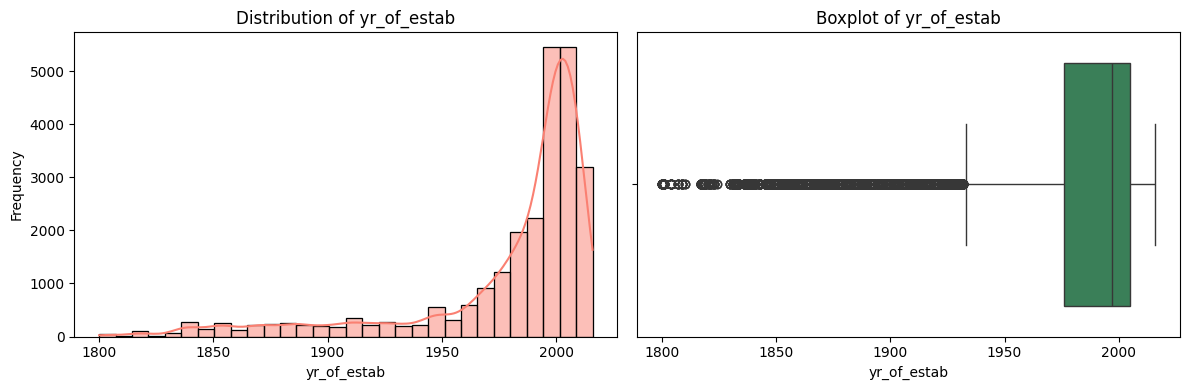


Feature: prevailing_wage
       prevailing_wage
count     25480.000000
mean      74455.814592
std       52815.942327
min           2.136700
25%       34015.480000
50%       70308.210000
75%      107735.512500
max      319210.270000
Missing values: 0 (0.00%)
Unique values: 25454

Skewness: 0.756
Kurtosis: 0.824

Outliers detected: 427 (1.68%)
Outlier range: below -76564.57 or above 218315.56

prevailing_wage is strongly skewed. Consider log, Box-Cox, or Yeo-Johnson transformation.
prevailing_wage has mildly heavy tails. Light transformation or scaling may help.

The variable is both skewed and heavy-tailed — consider transformation and outlier capping.
 Saved plot for 'prevailing_wage' → EDA_Charts\prevailing_wage_univariate_plot.png


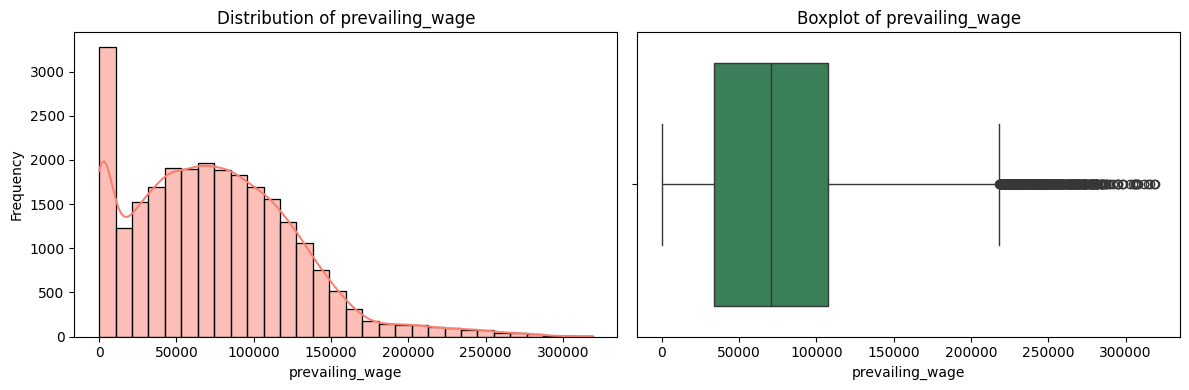

In [12]:

univariate_numerical_eda(df, 'no_of_employees')
univariate_numerical_eda(df, 'yr_of_estab')
univariate_numerical_eda(df, 'prevailing_wage')

In [13]:
def univariate_categorical_eda(df, column, save_folder="EDA_Categorical_Charts"):
    """
    Performs univariate EDA on a single categorical column.
    Displays frequency distribution, proportion, missing values,
    and visualizations (bar plot + pie chart).
    Automatically saves each plot to a folder.
    Provides ML preprocessing suggestions.
    """

    # Create folder if it doesn’t exist
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    print(f"\nFeature: {column}")
    print("="*45)

    # --- Summary ---
    total = len(df[column])
    missing = df[column].isna().sum()
    unique = df[column].nunique()
    mode_val = df[column].mode()[0] if unique > 0 else None

    print(f"Total observations: {total}")
    print(f"Missing values: {missing} ({(missing/total)*100:.2f}%)")
    print(f"Unique categories: {unique}")
    print(f"Most frequent category: {mode_val}")

    # --- Frequency Table ---
    freq = df[column].value_counts(dropna=False)
    perc = df[column].value_counts(normalize=True, dropna=False) * 100
    summary = pd.DataFrame({'Count': freq, 'Percentage': perc.round(2)})
    print("\nCategory Distribution:")
    print(summary)

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Bar Plot
    sns.countplot(x=df[column], palette='Set2', order=freq.index, ax=axes[0])
    axes[0].set_title(f"Frequency of {column}", fontsize=13)
    axes[0].set_xlabel(column)
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis='x', rotation=30)

    # Pie Chart
    axes[1].pie(freq, labels=freq.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title(f"Proportion of {column}", fontsize=13)

    plt.tight_layout()

    # --- Save Chart ---
    save_path = os.path.join(save_folder, f"{column}_categorical_plot.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"Saved plot for '{column}' → {save_path}")

    # Optional: show inline
    plt.show()

    plt.close(fig)

    # --- ML Preprocessing Suggestions ---
    if unique == 2:
        print(f" {column} is binary — suitable for Label Encoding (0/1).")
    elif 2 < unique <= 10:
        print(f" {column} has moderate categories — use One-Hot Encoding.")
    elif unique > 10:
        print(f" {column} has many unique categories — consider frequency encoding or feature grouping.")
    else:
        print(f" {column} seems low cardinality — standard encoding should work fine.")

    if (missing / total) > 0.05:
        print(f" Missing values exceed 5% — consider imputing or flagging missingness.")



Feature: case_id
Total observations: 25480
Missing values: 0 (0.00%)
Unique categories: 25480
Most frequent category: EZYV01

Category Distribution:
           Count  Percentage
case_id                     
EZYV01         1         0.0
EZYV02         1         0.0
EZYV03         1         0.0
EZYV04         1         0.0
EZYV05         1         0.0
...          ...         ...
EZYV25476      1         0.0
EZYV25477      1         0.0
EZYV25478      1         0.0
EZYV25479      1         0.0
EZYV25480      1         0.0

[25480 rows x 2 columns]
Saved plot for 'case_id' → EDA_Categorical_Charts\case_id_categorical_plot.png


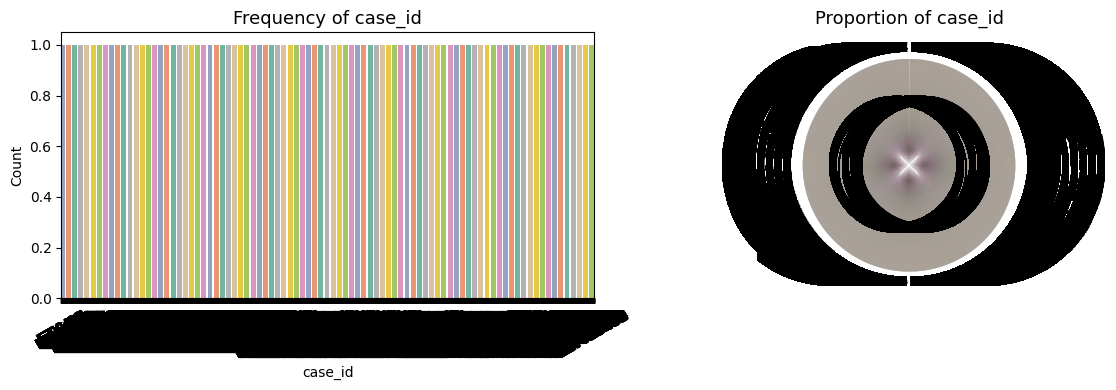

 case_id has many unique categories — consider frequency encoding or feature grouping.

Feature: continent
Total observations: 25480
Missing values: 0 (0.00%)
Unique categories: 6
Most frequent category: Asia

Category Distribution:
               Count  Percentage
continent                       
Asia           16861       66.17
Europe          3732       14.65
North America   3292       12.92
South America    852        3.34
Africa           551        2.16
Oceania          192        0.75
Saved plot for 'continent' → EDA_Categorical_Charts\continent_categorical_plot.png


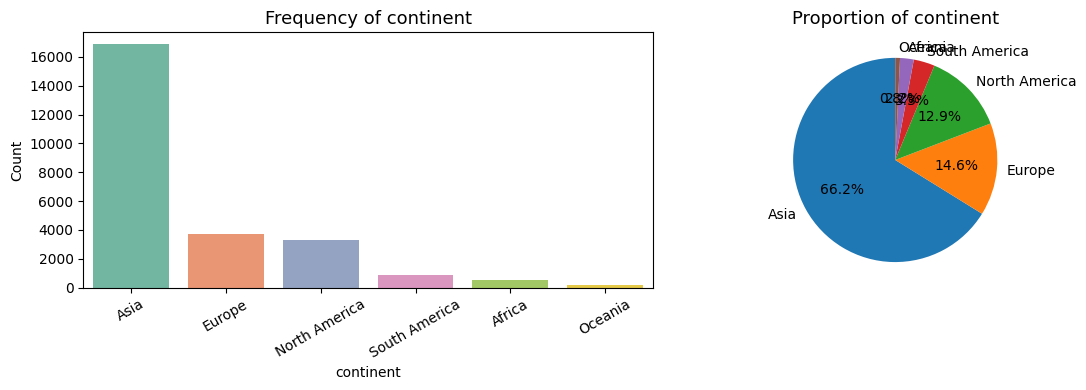

 continent has moderate categories — use One-Hot Encoding.

Feature: education_of_employee
Total observations: 25480
Missing values: 0 (0.00%)
Unique categories: 4
Most frequent category: Bachelor's

Category Distribution:
                       Count  Percentage
education_of_employee                   
Bachelor's             10234       40.16
Master's                9634       37.81
High School             3420       13.42
Doctorate               2192        8.60
Saved plot for 'education_of_employee' → EDA_Categorical_Charts\education_of_employee_categorical_plot.png


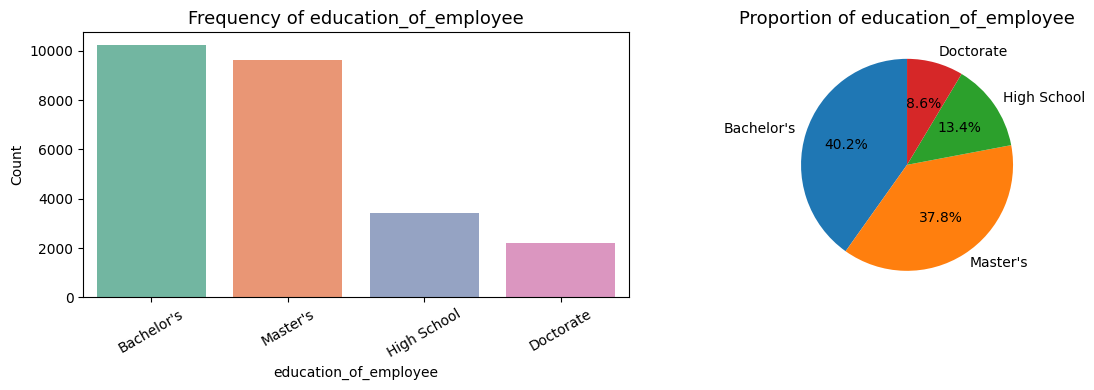

 education_of_employee has moderate categories — use One-Hot Encoding.

Feature: has_job_experience
Total observations: 25480
Missing values: 0 (0.00%)
Unique categories: 2
Most frequent category: Y

Category Distribution:
                    Count  Percentage
has_job_experience                   
Y                   14802       58.09
N                   10678       41.91
Saved plot for 'has_job_experience' → EDA_Categorical_Charts\has_job_experience_categorical_plot.png


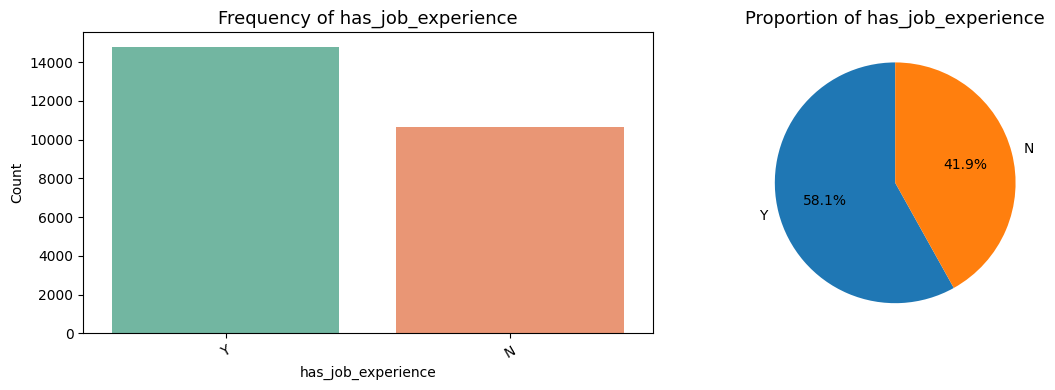

 has_job_experience is binary — suitable for Label Encoding (0/1).

Feature: requires_job_training
Total observations: 25480
Missing values: 0 (0.00%)
Unique categories: 2
Most frequent category: N

Category Distribution:
                       Count  Percentage
requires_job_training                   
N                      22525        88.4
Y                       2955        11.6
Saved plot for 'requires_job_training' → EDA_Categorical_Charts\requires_job_training_categorical_plot.png


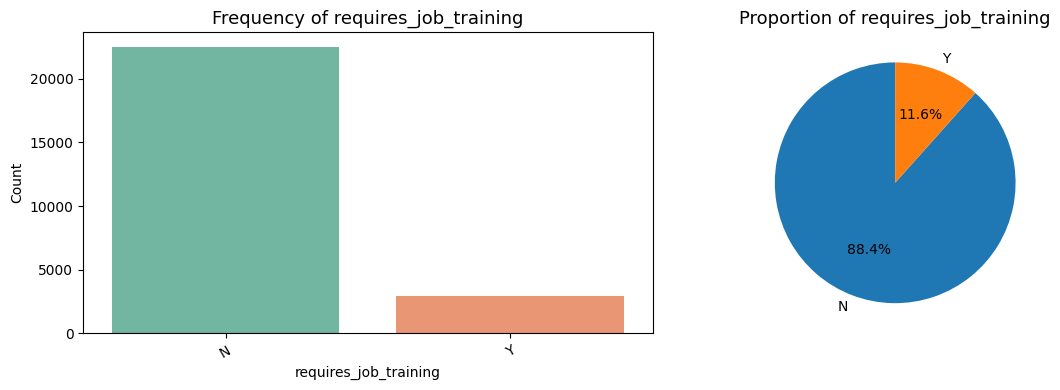

 requires_job_training is binary — suitable for Label Encoding (0/1).

Feature: region_of_employment
Total observations: 25480
Missing values: 0 (0.00%)
Unique categories: 5
Most frequent category: Northeast

Category Distribution:
                      Count  Percentage
region_of_employment                   
Northeast              7195       28.24
South                  7017       27.54
West                   6586       25.85
Midwest                4307       16.90
Island                  375        1.47
Saved plot for 'region_of_employment' → EDA_Categorical_Charts\region_of_employment_categorical_plot.png


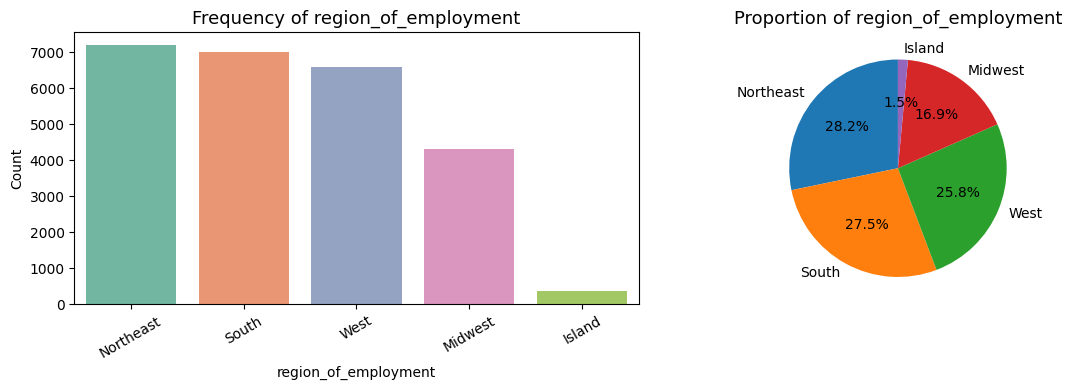

 region_of_employment has moderate categories — use One-Hot Encoding.

Feature: unit_of_wage
Total observations: 25480
Missing values: 0 (0.00%)
Unique categories: 4
Most frequent category: Year

Category Distribution:
              Count  Percentage
unit_of_wage                   
Year          22962       90.12
Hour           2157        8.47
Week            272        1.07
Month            89        0.35
Saved plot for 'unit_of_wage' → EDA_Categorical_Charts\unit_of_wage_categorical_plot.png


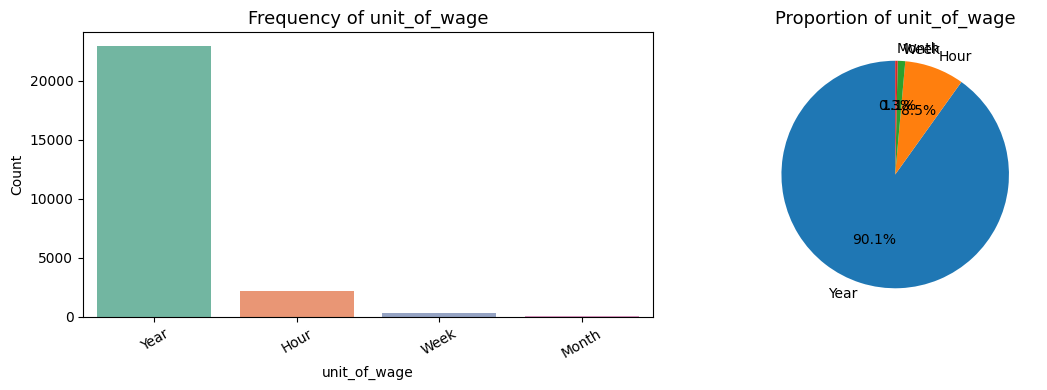

 unit_of_wage has moderate categories — use One-Hot Encoding.

Feature: full_time_position
Total observations: 25480
Missing values: 0 (0.00%)
Unique categories: 2
Most frequent category: Y

Category Distribution:
                    Count  Percentage
full_time_position                   
Y                   22773       89.38
N                    2707       10.62
Saved plot for 'full_time_position' → EDA_Categorical_Charts\full_time_position_categorical_plot.png


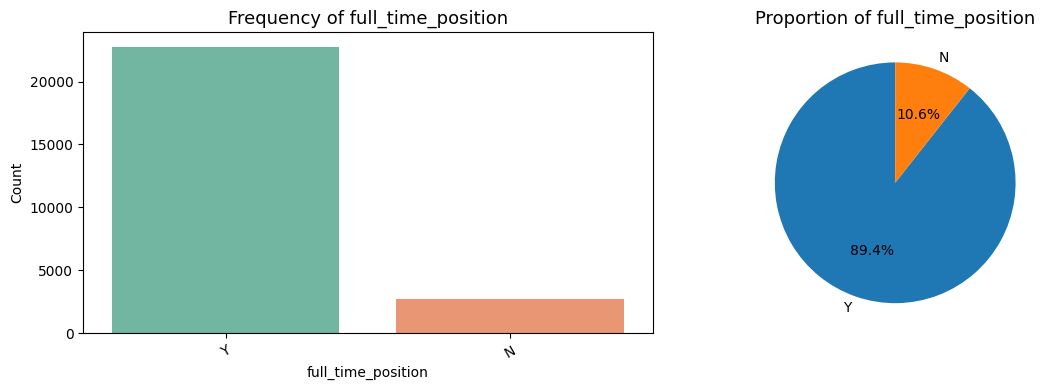

 full_time_position is binary — suitable for Label Encoding (0/1).

Feature: case_status
Total observations: 25480
Missing values: 0 (0.00%)
Unique categories: 2
Most frequent category: Certified

Category Distribution:
             Count  Percentage
case_status                   
Certified    17018       66.79
Denied        8462       33.21
Saved plot for 'case_status' → EDA_Categorical_Charts\case_status_categorical_plot.png


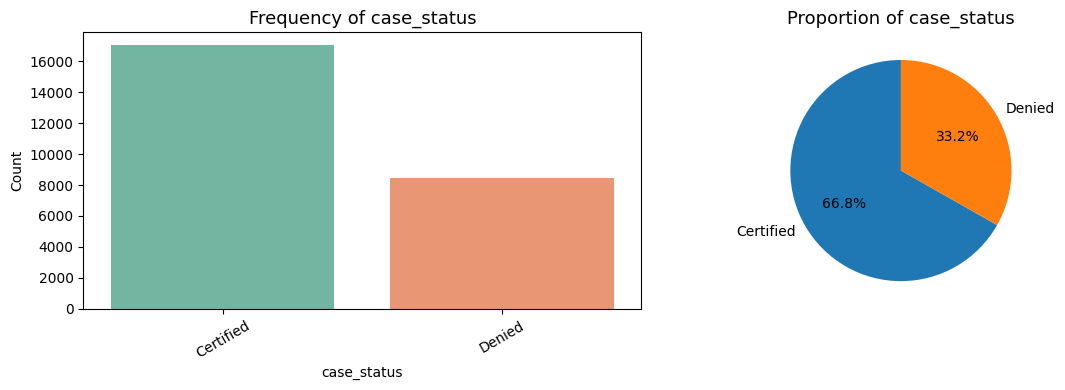

 case_status is binary — suitable for Label Encoding (0/1).


In [14]:
# We can loop to save time
for col in df.select_dtypes(include=['object']).columns.tolist():
    univariate_categorical_eda(df, col)

----------------------------------------------------------------
 ### **2. Bivariate analysis**
 ---------------------------------------------------------------

1. Numeric to Numeric

Cross Tabulation

In [35]:
# for col in df.select_dtypes(exclude=['object']).columns.tolist():  # Exclude Loan_Status
#         print(f"\nCross-tabulation: case_status vs {col}")
#         print(pd.crosstab(df[col], df['case_status'], normalize='index'))

In [15]:
def map_case_status(x):
    if x == 'Denied':
        return 0
    elif x == 'Certified':
        return 1
    else:
        return 'Missing record'

# lets apply our function

df['case_status'] = df['case_status'].apply(map_case_status)

In [17]:
df.head(10)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,0
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,1
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,0
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,0
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,1
5,EZYV06,Asia,Master's,Y,N,2339,2012,South,78252.1400,Year,Y,1
6,EZYV07,Asia,Bachelor's,N,N,4985,1994,South,53635.3900,Year,Y,1
7,EZYV08,North America,Bachelor's,Y,N,3035,1924,West,418.2298,Hour,Y,0
8,EZYV09,Asia,Bachelor's,N,N,4810,2012,Midwest,74362.1900,Year,Y,1
9,EZYV10,Europe,Doctorate,Y,N,2251,1995,South,67514.7600,Year,Y,1


In [19]:
# Lets find the numerical features
num_features = df.select_dtypes(include=['int64', 'float64']).columns

# convert to dataframe
num_features = pd.DataFrame(df[num_features])
num_features.head(10)

,no_of_employees,yr_of_estab,prevailing_wage,case_status
0,14513,2007,592.2029,0
1,2412,2002,83425.6500,1
2,44444,2008,122996.8600,0
3,98,1897,83434.0300,0
4,1082,2005,149907.3900,1
5,2339,2012,78252.1400,1
6,4985,1994,53635.3900,1
7,3035,1924,418.2298,0
8,4810,2012,74362.1900,1
9,2251,1995,67514.7600,1


In [20]:
def correlation_with_target(df1_cleaned, target_col, figsize=(10,2)):
    """
    Plots a heatmap showing correlation of each numeric feature against target_col.
    Returns a Series of correlations (sorted by absolute magnitude).
    """
    # Keep only numeric columns
    #numeric_df = df1.select_dtypes(include='number').copy()
    #numeric_df = df1.select_dtypes(include=['int64', 'float64']).columns
    #num_features
    if target_col not in num_features.columns:
        raise ValueError(f"Target column '{target_col}' must be numeric and present in the dataframe.")

    # compute correlations of every numeric column with the target
    corrs = num_features.corrwith(num_features[target_col]).drop(target_col)

    corrs_df = corrs.to_frame(name='corr').T  # shape (1, n)
    

    plt.figure(figsize=figsize)
    sns.heatmap(
        corrs_df,
        annot=True,
        fmt=".3f",
        cmap="coolwarm",
        center=0,
        vmin=-1,
        vmax=1,
        cbar_kws={'orientation': 'vertical', 'shrink':0.7}
    )
    plt.xticks(rotation=45, ha='right')
    plt.yticks([0], [target_col], rotation=0)
    plt.title(f'Correlation of numeric features with {target_col}', fontsize=12)
    plt.tight_layout()
    plt.show()

    # return sorted correlations for downstream use
    return corrs.reindex(corrs.abs().sort_values(ascending=False).index)


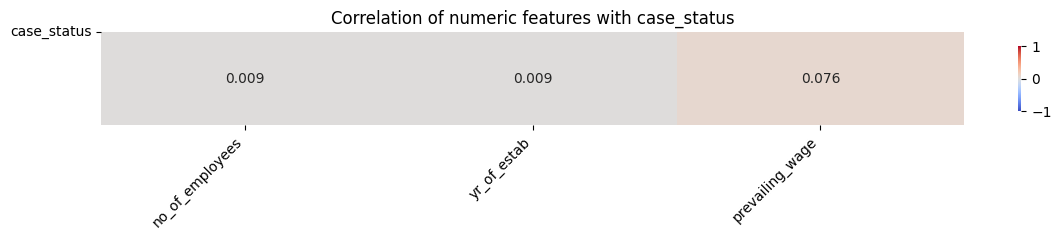

prevailing_wage    0.076198
no_of_employees    0.008677
yr_of_estab        0.008597
dtype: float64


In [21]:
corr_series = correlation_with_target(df, 'case_status', figsize=(12,2.5))
print(corr_series) 

SUMMARY BASED ON THE OUTPUT GENERATED FROM TOP CORRELATION WITH LOAD AMOUNT SHOWS BELOW WITH THIS INTERPRETATION
NOTE: ALL VALUES IS TO THE  NEAREST TWO NUMBER AFTER DECIMAL NUMBERS
Variable          | Correlation with Loan Amount|   Interpretation
------------------|------------------------------|------------------------|
prevailing_wage       | 0.076      | Very weak positive correlation, as prevailing wage increases, the likelihood  of the target variable slightly increases. But the relationship is not strong enough to be considered meaningful on its own.
no_of_employees      | 0.009      |  Essentially no correlation, the number of employees has almost no linear relationship with the target variable.
yr_of_estab            | 0.009      |  Also no correlation, how long the company has been established does not relate linearly to the target.

**Numeric–Categorical (Feature vs Target)**

In [22]:
def bivariate_num_cat(df, feature, target='case_status'):
    """
    Plots and summarizes relationship between a numerical feature and a categorical target.
    """
    print(f" Feature: {feature} vs {target}")
    print("="*50)

    # Group summary
    summary = df.groupby(target)[feature].describe()[['mean','std','min','max']]
    print(summary)
    print()

    plt.figure(figsize=(10,5))

    # Boxplot + mean line
    sns.boxplot(x=target, y=feature, data=df, palette='Set2')
    plt.title(f'{feature} across {target} categories', fontsize=13)
    plt.xlabel(target)
    plt.ylabel(feature)
    #plt.show()


 Feature: no_of_employees vs case_status
                    mean           std   min       max
case_status                                           
0            5385.538407  22382.755904 -26.0  594472.0
1            5807.018157  23119.575259 -26.0  602069.0

 Feature: yr_of_estab vs case_status
                    mean        std     min     max
case_status                                        
0            1978.893406  42.541819  1800.0  2016.0
1            1979.666765  42.278601  1800.0  2016.0

 Feature: prevailing_wage vs case_status
                     mean           std     min        max
case_status                                               
0            68748.681580  53890.166031  2.9561  319210.27
1            77293.619243  52042.715576  2.1367  318446.05



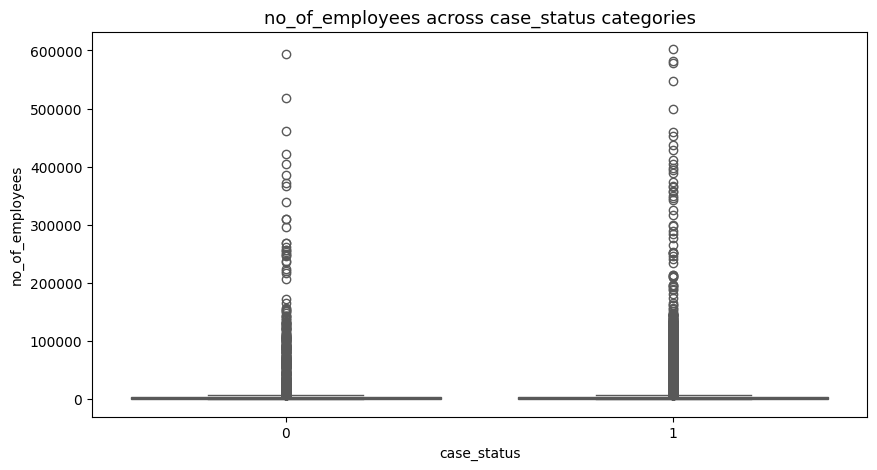

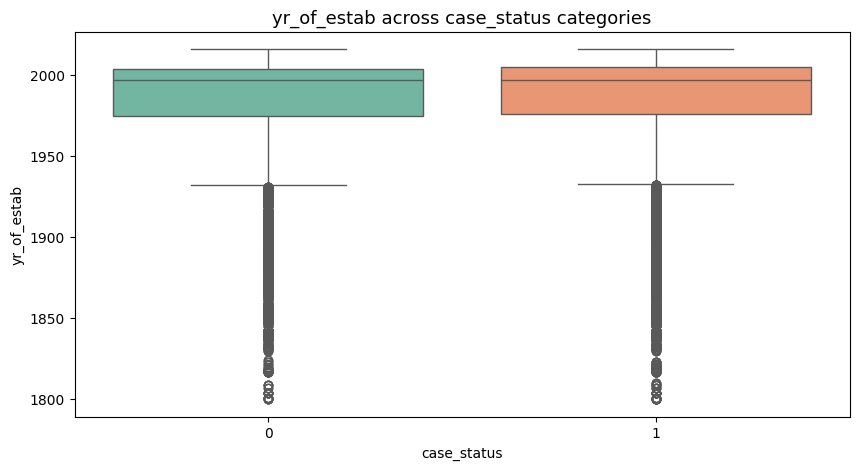

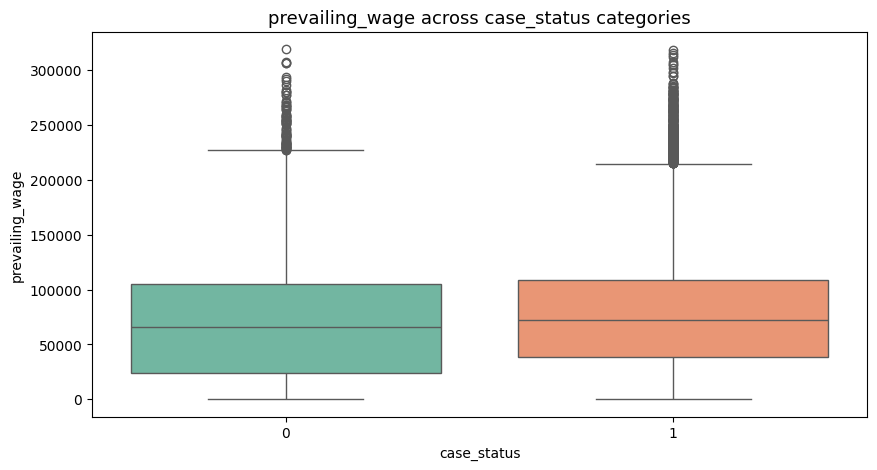

In [23]:
bivariate_num_cat(df, "no_of_employees", target='case_status')
bivariate_num_cat(df, "yr_of_estab", target='case_status')
bivariate_num_cat(df, "prevailing_wage", target='case_status')

In [24]:
from scipy.stats import pearsonr

def numeric_bivariate_plot(df, x_col, y_col):
    """
    Plots the relationship between two numeric variables with a regression line
    and displays the correlation coefficient.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset containing the numeric columns
    x_col : str
        Name of the first numeric variable (x-axis)
    y_col : str
        Name of the second numeric variable (y-axis)
    """

    # Calculate correlation coefficient
    corr, p_value = pearsonr(df[x_col], df[y_col])

    # Create plot
    plt.figure(figsize=(8, 5))
    sns.regplot(data=df, x=x_col, y=y_col, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    
    # Title and labels
    plt.title(f"{y_col} vs {x_col}\nCorrelation: {corr:.3f} (p={p_value:.3f})", fontsize=13)
    plt.xlabel(x_col, fontsize=11)
    plt.ylabel(y_col, fontsize=11)
    plt.grid(alpha=0.3)
    #plt.show()


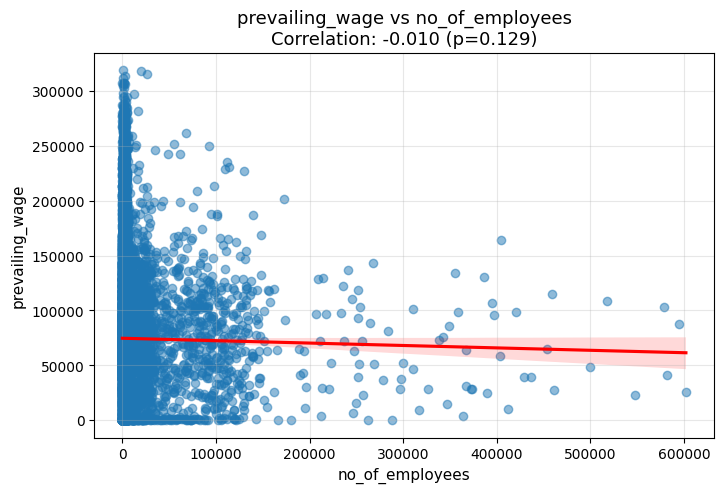

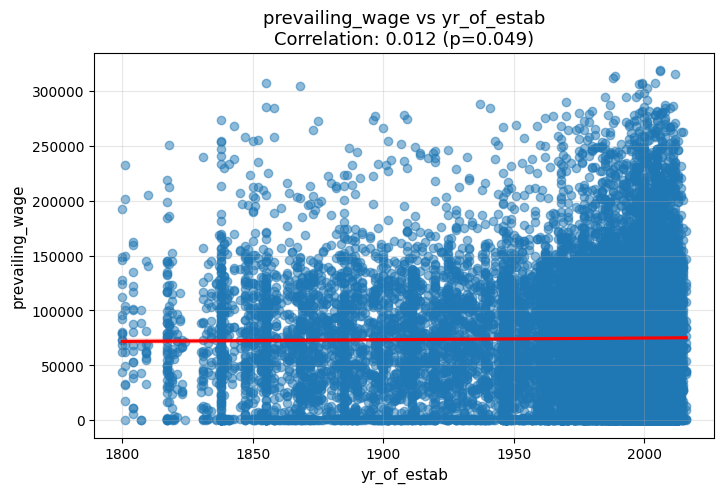

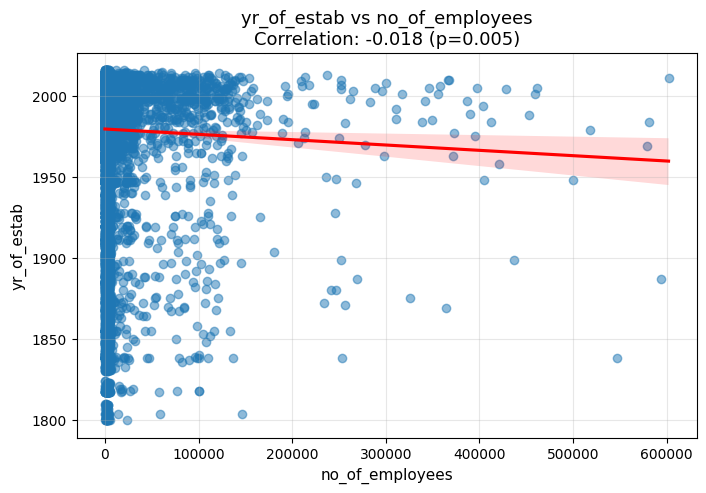

In [25]:
numeric_bivariate_plot(df, 'no_of_employees', 'prevailing_wage')
numeric_bivariate_plot(df, 'yr_of_estab', 'prevailing_wage')
numeric_bivariate_plot(df, 'no_of_employees', 'yr_of_estab')

 ###  Trivariate analysis

In [22]:
def trivariate_plot(df, x_col, y_col, hue_col):
    """
    Visualizes the relationship between two numeric variables
    with a third categorical variable shown by color (hue).
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataset.
    x_col : str
        The first numeric feature (x-axis).
    y_col : str
        The second numeric feature (y-axis).
    hue_col : str
        The categorical feature (color grouping).
    """

    plt.figure(figsize=(8, 6))
    sns.lmplot(
        data=df, 
        x=x_col, 
        y=y_col, 
        hue=hue_col, 
        height=6, 
        aspect=1.2, 
        scatter_kws={'alpha':0.6}, 
        line_kws={'linewidth':2}
    )
    plt.title(f"{y_col} vs {x_col} by {hue_col}", fontsize=13)
    plt.xlabel(x_col, fontsize=11)
    plt.ylabel(y_col, fontsize=11)
    plt.grid(alpha=0.3)
    #plt.show()


<Figure size 800x600 with 0 Axes>

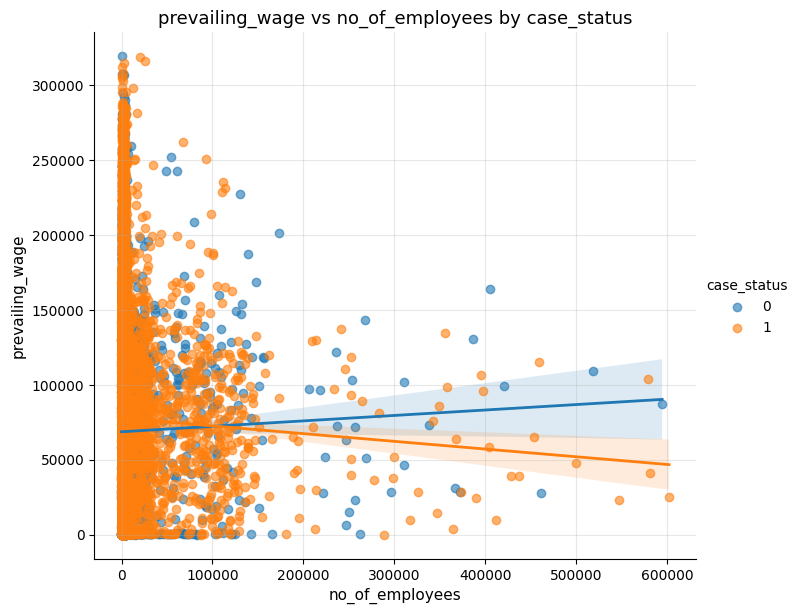

In [23]:
trivariate_plot(df, 'no_of_employees', 'prevailing_wage', 'case_status')

<Figure size 800x600 with 0 Axes>

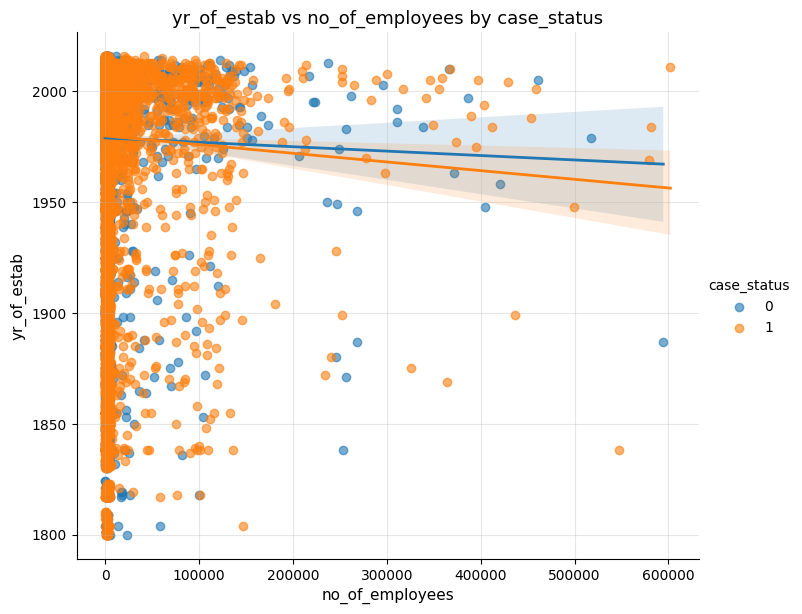

In [24]:
trivariate_plot(df, 'no_of_employees', 'yr_of_estab', 'case_status')

<Figure size 800x600 with 0 Axes>

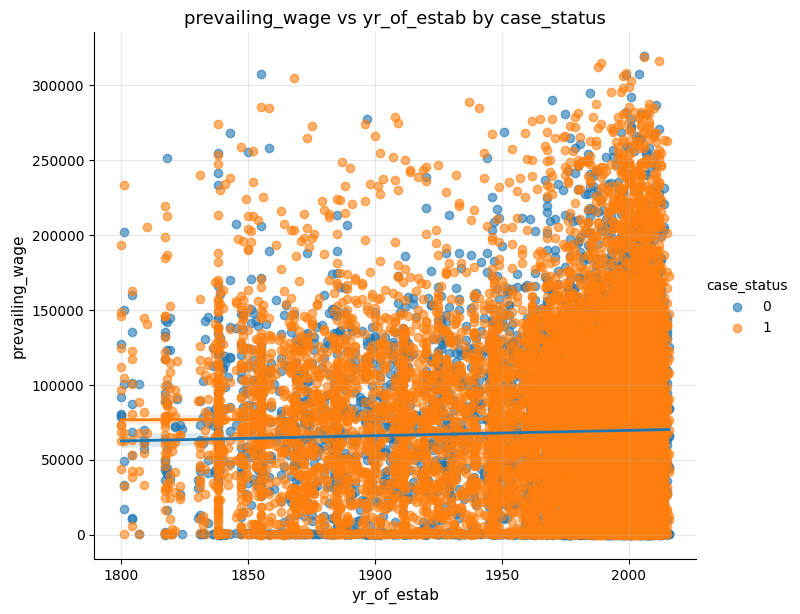

In [25]:
trivariate_plot(df, 'yr_of_estab', 'prevailing_wage', 'case_status')

In [26]:
def grouped_summary(df):
    """
    Computes summary statistics grouped by case_status.
    """
    summary = df.groupby('case_status').mean(numeric_only=True).round(2)
    return summary


In [27]:
grouped_summary(num_features)

,no_of_employees,yr_of_estab,prevailing_wage
case_status,,,
0,5385.54,1978.89,68748.68
1,5807.02,1979.67,77293.62


##### prevailing_wage

Certified cases have a higher average wage (≈ $77,294) than Denied cases (≈ $68,749).

Interpretation: Higher offered wages tend to increase the likelihood of certification.
This aligns with real-world expectations jobs offering higher wages are more likely to be considered legitimate or specialized enough to be certified.

 ##### no_of_employees


Certified companies have slightly more employees (5807 vs 5385 on average).

The difference isn’t huge, but it suggests larger organizations may have a marginal advantage in getting certifications possibly due to stronger compliance systems or reputation.

##### yr_of_estab (Year of Establishment)

The averages are nearly identical (1978.89 vs 1979.67).

So, the age of the company does not significantly affect case approval.
This matches our earlier correlation results (≈ 0.0086 — near zero)

In [33]:
from scipy.stats import mannwhitneyu

def numeric_feature_selection(df):
    print("=== Mann–Whitney U Test for Numeric Features ===")
    numeric_features = ['no_of_employees', 'yr_of_estab', 'prevailing_wage']
    results = []

    for feature in numeric_features:
        if feature in df.columns:
            group_certified = df[df['case_status'] == 1][feature]
            group_denied = df[df['case_status'] == 0][feature]

            stat, p = mannwhitneyu(group_certified, group_denied, alternative='two-sided')
            results.append({'Feature': feature, 'p-value': p})
            print(f"{feature}: p = {p:.4f} {'(Significant)' if p < 0.05 else '(Not significant)'}")

    return pd.DataFrame(results)


In [31]:
from scipy.stats import chi2_contingency

def categorical_feature_selection(df):
    print("\n=== Chi-square Test for Categorical Features ===")
    categorical_features = ['continent', 'education_of_employee', 'has_job_experience',
                            'requires_job_training', 'region_of_employment',
                            'unit_of_wage', 'full_time_position']
    results = []

    for feature in categorical_features:
        if feature in df.columns:
            contingency_table = pd.crosstab(df[feature], df['case_status'])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            results.append({'Feature': feature, 'p-value': p})
            print(f"{feature}: p = {p:.4f} {'(Significant)' if p < 0.05 else '(Not significant)'}")

    return pd.DataFrame(results)


In [34]:
num_results = numeric_feature_selection(df)
cat_results = categorical_feature_selection(df)

final_results = pd.concat([num_results, cat_results], ignore_index=True)
final_results = final_results.sort_values(by='p-value')
print("\n=== Summary of Feature Significance ===")
print(final_results)


=== Mann–Whitney U Test for Numeric Features ===
no_of_employees: p = 0.0000 (Significant)
yr_of_estab: p = 0.0008 (Significant)
prevailing_wage: p = 0.0000 (Significant)

=== Chi-square Test for Categorical Features ===
continent: p = 0.0000 (Significant)
education_of_employee: p = 0.0000 (Significant)
has_job_experience: p = 0.0000 (Significant)
requires_job_training: p = 0.1856 (Not significant)
region_of_employment: p = 0.0000 (Significant)
unit_of_wage: p = 0.0000 (Significant)
full_time_position: p = 0.0447 (Significant)

=== Summary of Feature Significance ===
                 Feature        p-value
4  education_of_employee   0.000000e+00
8           unit_of_wage  5.193385e-240
5     has_job_experience  1.922560e-206
3              continent   8.828798e-74
7   region_of_employment   2.338664e-63
2        prevailing_wage   3.134782e-39
0        no_of_employees   2.405143e-06
1            yr_of_estab   7.957749e-04
9     full_time_position   4.469975e-02
6  requires_job_training  